# Projekt - Text Analytics

In [1]:
import pandas as pd
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer # für BoW
from sklearn.feature_extraction.text import TfidfVectorizer # für TF-IDF

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from save_functions import *


## Einlesen der Textfiles

Datensatz - Kaggle: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification/code

Im Ordner BBC gibt es für jede News Kategorie einen Unterordner in welchen die Artikel gespeichert sind.

- business
- entertainment
- politics
- sport
- tech

Die einzelnen Textfiles beinhalten in der ersten Zeile den Titel und darunter den Inhalt. 

Für jedes Textfile wird der Titel des Artikels und den Artikel extrahiert und anschliessend in einem Dataframe abgespeichert. 

In [2]:
path = "./bbc/"
directory = []
file = []
title = []
text = []
label = []
for root, dir, files in os.walk(path):
    try:
        files.remove("README.TXT")
    except:
        pass
    for filename in files:
        directory.append(root)
        file.append(filename)
        label.append(root.split("/")[-1])
        fullpathfile = os.path.join(root,filename)
        with open(fullpathfile,"r", encoding = "utf8", errors = "ignore") as infile:
            intext = ""
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + " " + line.replace('\n','')
            text.append(intext)

bbc_df = pd.DataFrame(list(zip(directory,file,title,text,label)),
                columns = ['directory', 'file', 'title', 'text', 'label'])


In [3]:
bbc_df.head()

,directory,file,title,text,label
0,./bbc/business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarn...,business
1,./bbc/business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against...,business
2,./bbc/business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yu...,business
3,./bbc/business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices ...,business
4,./bbc/business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dom...,business


In [4]:
# Anzahl Dokumenten
bbc_df.shape

(2225, 5)

In [5]:
bbc_df.isnull().sum()

directory    0
file         0
title        0
text         0
label        0
dtype: int64

In [6]:
bbc_df['label'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

## ADD STATISCHE ANALYSE

In [7]:
1

1

## Labels --> Numeric

Hier werden die Labels in numerische Label umgewandelt.

In [3]:
bbc_df['label_num'] = LabelEncoder().fit_transform(bbc_df['label'])
bbc_df.head()

,directory,file,title,text,label,label_num
0,./bbc/business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarn...,business,0
1,./bbc/business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against...,business,0
2,./bbc/business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yu...,business,0
3,./bbc/business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices ...,business,0
4,./bbc/business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dom...,business,0


In [4]:
label_lookup_table = {0: 'business',
                    1: 'entertainment',
                    2: 'politics',
                    3: 'sport',
                    4: 'tech'}

# Text Preprocessing

In diesem Teil werden verschiedene Text preprocessing Schritte auf die einzelnen Dokumenten ausgeführt.

In [5]:
def lowercase(text):
    """
    Alle Wörter im Dokument in lowercase umwandeln
    """
    # Alle Wörter in lowercase umwandeln
    res = text.lower()
    return res

In [6]:
def remove_stopwords(text):
    """
    Die englischen Stoppwörter entfernen
    """
    STOPWORDS = set(stopwords.words('english'))
    res = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return res

In [7]:
def remove_numbers(text):
    """
    Entfernung von Zahlen
    """
    NUMBERS = '[0-9]'
    res = re.sub(NUMBERS, '', str(text))
    return res

In [8]:
def remove_symbols(text):
    """
    Entfernung von speziellen characters
    """
    SPECIAL_CHARACTERS = '[^A-Za-z0-9.]+'
    res = re.sub(SPECIAL_CHARACTERS, ' ', str(text))
    return res

In [9]:
def remove_punct(text):
    """
    Entfernung von Punktuation
    """
    PUNCTUATIONS = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in text:
        if ele in PUNCTUATIONS:
            text = text.replace(ele, "")
    return text

In [10]:
def porter_stem(text):
    """
    Andwendung von Porterstemmer

    """
    res = ' '.join(PorterStemmer().stem(word) for word in text.split())
    return res

In [11]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
def lemmatization(text, pos = False):
    """
    Anwendung von Lemmatisierung

    """
    if pos == True:
        lemmatizer = WordNetLemmatizer()
        res = ' '.join(lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split())
    else:
        lemmatizer = WordNetLemmatizer()
        res = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return res

In [13]:
def remove_char(text):
    """
    Entferne Wörter mit länge = 1
    """
    res = ' '.join(word for word in text.split() if len(word)>1)
    return res

In [14]:
def clean_text(text, lower = False, stopwords = False, numbers = False, symbols = False, punct = False, char = False, porter_stemmer = False, lemmatizer = False):
    """
    Textbereinigung

    Args:
        text (_type_): _description_
        lower (bool, optional): Anwendung von lowercase() Funktion. Defaults to False.
        stopwords (bool, optional): Anwendung von remove_stopwords() Funktion. Defaults to False.
        numbers (bool, optional): Anwendung von remove_numbers() Funktion. Defaults to False.
        symbols (bool, optional): Anwendung von remove_symbols() Funktion. Defaults to False.
        punct (bool, optional): Anwendung von remove_punct() Funktion. Defaults to False.

    Returns:
        str: Bereinigter Text
    """

    #----- Text to lowercase
    if lower == True:
        text = lowercase(text)
    # text = text.lower()

    #----- Entferne die Stoppwörter
    if stopwords == True:
        text = remove_stopwords(text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    #----- Entferne Zahlen
    if numbers == True:
        text = remove_numbers(text)
    # text = re.sub(NUMBERS, '', text)

    #----- Entferne Symbole
    if symbols == True:
        text = remove_symbols(text)
    # text = re.sub(SPECIAL_CHARACTERS, ' ', text)

    #----- Entferne Punctuations
    if punct == True:
        text = remove_punct(text)
    # for ele in text:
    #     if ele in PUNCTUATIONS:
    #         text = text.replace(ele, "")

    #----- Entferne Wörter mit Länge 1
    if char == True:
        text = remove_char(text)

    #----- Porter Stemmer
    if porter_stemmer == True:
        text = porter_stem(text)

    #----- Lemmatizer
    if lemmatizer == True:
        text = lemmatization(text, True)

   
    return text
    

In [20]:
# cleaning_args = (True, True, True, True, True, True, False)

In [15]:
#--------------------------------------------
# Anwendung der Textbereinigungs Funktion
#--------------------------------------------
cleaning_args = (True, True, True, True, True, True, False, False)
# cleaning_args = (False, False, False, False, False, False, False, False)
bbc_df['text_clean'] = bbc_df['text'].apply(clean_text, args = cleaning_args)

# Mit Lemmatisierung
# cleaning_args = (True, True, True, True, True, True, False, True)
# bbc_df['text_clean'] = bbc_df['text'].apply(clean_text, args = cleaning_args)

In [22]:
#--------------------------------------------
# Beispiel - Bereinigter Text
#--------------------------------------------
bbc_df['text_clean'][0]

'quarterli profit us media giant timewarn jump bn three month decemb year earlier firm one biggest investor googl benefit sale high speed internet connect higher advert sale timewarn said fourth quarter sale rose bn bn profit buoy one off gain offset profit dip warner bro less user aol time warner said friday own search engin googl internet busi aol mix fortun lost subscrib fourth quarter profit lower preced three quarter howev compani said aol underli profit except item rose back stronger internet advertis revenu hope increas subscrib offer onlin servic free timewarn internet custom tri sign aol exist custom high speed broadband timewarn also restat result follow probe us secur exchang commiss sec close conclud time warner fourth quarter profit slightli better analyst expect film divis saw profit slump help box offic flop alexand catwoman sharp contrast year earlier third final film lord ring trilog boost result full year timewarn post profit bn perform revenu grew bn our financi perf

In [16]:
# Save cleaning Schritte in einem Textfile im Ordner Results
base_dir = "./results/"
foldername = "Full_text_cleaning"
save_cleaning_steps(base_dir, foldername, str(cleaning_args))

## Train- & Test-Split

Die Daten in Trainings- und Testdaten aufteilen. 

80% Trainingsdaten und 20% Testdaten

In [17]:
X_train, X_test, y_train, y_test = train_test_split(bbc_df['text_clean'], bbc_df['label_num'], random_state = 0, test_size=0.2)

# Variante 1: CountVectorizer

In [25]:
def cnt_vectorizer(default = True):
    #--------------------------------------------
    # Mit Default einstellungen
    #--------------------------------------------
    if default == True:
        count_vectorizer = CountVectorizer()
        save_count_vectorizer_parameters(base_dir, foldername, 'default Einstellungen')
    else:
        #--------------------------------------------
        # mit definierten Parameter
        #--------------------------------------------
        ngram_range = (1,1)
        max_features = 3000
        min_df = 5 # Minimum number of documents that should contain this feature
        max_df = 0.7 # Only the words which occur in a maximum of max_df percentage of all the documents. 
        count_vectorizer = CountVectorizer(ngram_range=ngram_range,max_features=max_features, min_df=min_df, max_df=max_df)
        save_count_vectorizer_parameters(base_dir, foldername, ('ngram_range: '+str(ngram_range)+' max_features: '+str(max_features)+' min_df: '+str(min_df)+' max_df: '+str(max_df)))
    return count_vectorizer


In [26]:
count_vectorizer = cnt_vectorizer(default = False)
# count_vectorizer = cnt_vectorizer(default = True)

In [27]:
# # --------------------------------------------
# # Anzahl Features - X_train
# # --------------------------------------------
# X_train_bow = count_vectorizer.fit_transform(X_train)
# len(count_vectorizer.get_feature_names())

## Cross-Validation mit CountVectorizer

In diesem Abschnitt werden verschiedene Algorithmen ausprobiert und mit Hilfe von Hyperparameter Tuning werden die Parameter optimiert. Mit Cross-Validation wird die performance des Schätzern evaluiert.

In [28]:
models = [RandomForestClassifier(),
         MultinomialNB(),
         LinearSVC(),
         LogisticRegression()]

param_grid = [[{'model__n_estimators': [100,200,300]}],
            [{'model__alpha': [1.0,2.0,2.5]}],
            [{'model__C': [0.5,1.0,2.0], 'model__max_iter': [10000]}],
            [{'model__C': [1.0,2.0,2.5], 'model__max_iter': [200]}]]

# Default Settings / ohne hyperparameter tuning
# param_grid = [[{'model__n_estimators': [100]}],
#             [{'model__alpha': [1.0]}],
#             [{'model__C': [1.0], 'model__max_iter': [1000]}],
#             [{'model__C': [1.0], 'model__max_iter': [100]}]]
            
CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

vectorizer = count_vectorizer

entries = []
i = 0
for model in models:
    print(model)
    model_name = model.__class__.__name__
    model_pipe = Pipeline([('vectorizer', vectorizer), ('model', model)])
    clf = GridSearchCV(model_pipe, param_grid[i], scoring='accuracy', cv=CV)
    clf.fit(X_train, y_train)
    best_index = np.where(clf.cv_results_['mean_test_score'] == max(clf.cv_results_['mean_test_score']))
    best_param = list(clf.best_params_.keys())
    for key in best_param:
        new_key = key.split("model__",1)[1]
        clf.best_params_[new_key] = clf.best_params_.pop(key)
    for fold_idx in range(0,CV):
        tag = 'split'+str(fold_idx)+'_test_score'
        entries.append((model_name, fold_idx+1, clf.cv_results_[tag][best_index][0], clf.best_params_))
    i += 1
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'best params']) 

save_count_vectorizer_CV_results(base_dir, foldername, str(models), str(param_grid), cv_df.to_string())

RandomForestClassifier()
MultinomialNB()
LinearSVC()
LogisticRegression()


In [29]:
cv_df

,model_name,fold_idx,accuracy,best params
0,RandomForestClassifier,1,0.966292,{'n_estimators': 300}
1,RandomForestClassifier,2,0.966292,{'n_estimators': 300}
2,RandomForestClassifier,3,0.971910,{'n_estimators': 300}
3,RandomForestClassifier,4,0.969101,{'n_estimators': 300}
4,RandomForestClassifier,5,0.971910,{'n_estimators': 300}
5,MultinomialNB,1,0.974719,{'alpha': 2.0}
6,MultinomialNB,2,0.963483,{'alpha': 2.0}
7,MultinomialNB,3,0.974719,{'alpha': 2.0}
8,MultinomialNB,4,0.966292,{'alpha': 2.0}
9,MultinomialNB,5,0.980337,{'alpha': 2.0}


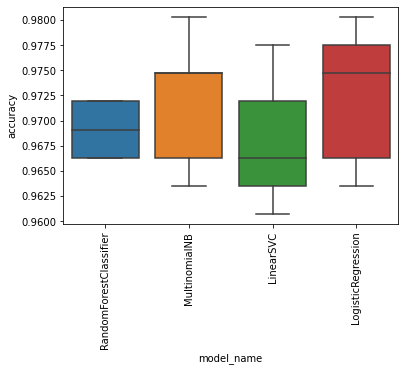

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
None
plt.savefig(base_dir+foldername+"/model_cv_boxplot.png", facecolor = 'white', transparent=False, bbox_inches='tight')

In [31]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.967978
LogisticRegression        0.972472
MultinomialNB             0.971910
RandomForestClassifier    0.969101
Name: accuracy, dtype: float64

## Vorhersage - Testset

Hier wird mit dem besten Model einer vorhersage auf den Testdaten gemacht. 

In [32]:
def test_prediction(cv_df, X_train, y_train, y_test, vectorizer, filename):
    model_name = cv_df.model_name.unique()
    for model in model_name:
        if model == 'LinearSVC':
            estimator = LinearSVC(C = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('max_iter'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred, digits = 4)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/LinearSVC_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LinearSVC_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LinearSVC_wrong_pred_TFIDF')
        elif model == 'LogisticRegression':
            estimator = LogisticRegression(C = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('max_iter'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred, digits = 4)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/LogisicRegression_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LogisicRegression_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LogisicRegression_wrong_pred_TFIDF')
        elif model == 'MultinomialNB':
            estimator = MultinomialNB(alpha = cv_df[cv_df['model_name'] == 'MultinomialNB'].reset_index()['best params'][0].get('alpha'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred, digits = 4)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/MultinomialNB_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/MultinomialNB_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/MultinomialNB_wrong_pred_TFIDF')
        elif model == 'RandomForestClassifier':
            estimator = RandomForestClassifier(n_estimators=cv_df[cv_df['model_name'] == 'RandomForestClassifier'].reset_index()['best params'][0].get('n_estimators'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred, digits = 4)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/RandomForest_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/RandomForest_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/RandomForest_wrong_pred_TFIDF')

In [33]:
test_prediction(cv_df, X_train, y_train, y_test, count_vectorizer, filename = '/test_prediction_count_vectorizer')

### Vorhersage mit VotingClassifier

In [34]:
def test_prediction_voting_classifier(cv_df, X_train, y_train, y_test, vectorizer, filename):
    from sklearn.calibration import CalibratedClassifierCV
    model_name = cv_df.model_name.unique()
    estimators = []
    for model in model_name:
        if model == 'LinearSVC':
            estimator = LinearSVC(C = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('max_iter'))
            estimators.append(("p1", make_pipeline(vectorizer, CalibratedClassifierCV(estimator))))
        elif model == 'LogisticRegression':
            estimator = LogisticRegression(C = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('max_iter'))
            estimators.append(("p2", make_pipeline(vectorizer, estimator)))
        elif model == 'MultinomialNB':
            estimator = MultinomialNB(alpha = cv_df[cv_df['model_name'] == 'MultinomialNB'].reset_index()['best params'][0].get('alpha'))
            estimators.append(("p3", make_pipeline(vectorizer, estimator)))
        elif model == 'RandomForestClassifier':
            estimator = RandomForestClassifier(n_estimators=cv_df[cv_df['model_name'] == 'RandomForestClassifier'].reset_index()['best params'][0].get('n_estimators'))
            estimators.append(("p4", make_pipeline(vectorizer, estimator)))
    p5 = make_pipeline(VotingClassifier(estimators=estimators, voting='soft'))
    p5.fit(X_train, y_train)
    y_pred = p5.predict(X_test)
    conf_matrix = confusion_matrix(y_test,y_pred)
    report = classification_report(y_test,y_pred, digits = 4)
    save_test_prediction(base_dir, foldername, filename, 'Voting Classifier', str(conf_matrix), str(report))
    save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/VotingClassifier_pred_labels')
    if vectorizer == count_vectorizer:
        save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/VotingClassifier_wrong_pred')
    else:
        save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/VotingClassifier_wrong_pred_TFIDF')


In [35]:
test_prediction_voting_classifier(cv_df, X_train, y_train, y_test, count_vectorizer, filename = '/test_prediction_count_vectorizer_voting_classifier')

# Variante 2: TF-IDF

funktion einstellungen ausprobieren, ngrams, usw...

In [36]:
def tfidf_vectorizer(default = True):
    #--------------------------------------------
    # Mit Default einstellungen
    #--------------------------------------------
    if default == True:
        tfidf_vectorizer = TfidfVectorizer()
        save_tfidf_vectorizer_parameters(base_dir, foldername, 'default Einstellungen')
    else:
        #--------------------------------------------
        # mit definierten Parameter
        #--------------------------------------------
        ngram_range = (1,1)
        max_features = 3000
        min_df = 5 # Minimum number of documents that should contain this feature
        max_df = 0.7 # Only the words which occur in a maximum of max_df percentage of all the documents. 
        tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range,max_features=max_features, min_df=min_df, max_df=max_df)
        save_tfidf_vectorizer_parameters(base_dir, foldername, ('ngram_range: '+str(ngram_range)+' max_features: '+str(max_features)+' min_df: '+str(min_df)+' max_df: '+str(max_df)))
    return tfidf_vectorizer


In [37]:
TFIDF_vectorizer = tfidf_vectorizer(default = False)
# TFIDF_vectorizer = tfidf_vectorizer(default = True)

## Cross-Validation mit TF-IDf

In [38]:
models = [RandomForestClassifier(),
         MultinomialNB(),
         LinearSVC(),
         LogisticRegression()]

param_grid = [[{'model__n_estimators': [100,200,300]}],
            [{'model__alpha': [1.0,2.0,2.5]}],
            [{'model__C': [0.5,1.0,2.0], 'model__max_iter': [10000]}],
            [{'model__C': [1.0,2.0,2.5], 'model__max_iter': [200]}]]

# Default Settings / ohne hyperparameter tuning
# param_grid = [[{'model__n_estimators': [100]}],
#             [{'model__alpha': [1.0]}],
#             [{'model__C': [1.0], 'model__max_iter': [1000]}],
#             [{'model__C': [1.0], 'model__max_iter': [100]}]]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

vectorizer = TFIDF_vectorizer

entries = []
i = 0
for model in models:
    print(model)
    model_name = model.__class__.__name__
    model_pipe = Pipeline([('vectorizer', vectorizer), ('model', model)])
    clf = GridSearchCV(model_pipe, param_grid[i], scoring='accuracy', cv=CV)
    clf.fit(X_train, y_train)
    best_index = np.where(clf.cv_results_['mean_test_score'] == max(clf.cv_results_['mean_test_score']))
    best_param = list(clf.best_params_.keys())
    for key in best_param:
        new_key = key.split("model__",1)[1]
        clf.best_params_[new_key] = clf.best_params_.pop(key)
    for fold_idx in range(0,CV):
        tag = 'split'+str(fold_idx)+'_test_score'
        entries.append((model_name, fold_idx+1, clf.cv_results_[tag][best_index][0], clf.best_params_))
    i += 1
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'best params']) 

save_tfidf_vectorizer_CV_results(base_dir, foldername, str(models), str(param_grid), cv_df.to_string())

RandomForestClassifier()
MultinomialNB()
LinearSVC()
LogisticRegression()


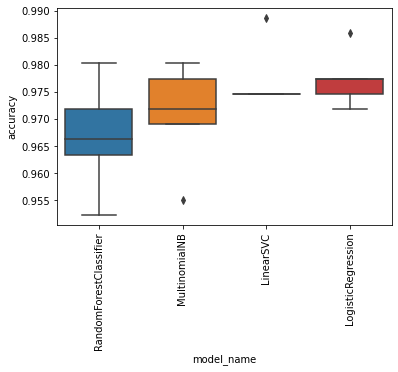

In [39]:
import seaborn as sns
g = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
None
plt.savefig(base_dir+foldername+"/model_tfidf_cv_boxplot.png", facecolor = 'white', transparent=False, bbox_inches='tight')

In [40]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.977528
LogisticRegression        0.977528
MultinomialNB             0.970787
RandomForestClassifier    0.966854
Name: accuracy, dtype: float64

## Vorhersage - Testset

In [41]:
test_prediction(cv_df, X_train, y_train, y_test, TFIDF_vectorizer, filename = '/test_prediction_tfidf_vectorizer')

### Vorhersage mit VotingClassifier

In [42]:
test_prediction_voting_classifier(cv_df, X_train, y_train, y_test, TFIDF_vectorizer, filename = '/test_prediction_tfidf_vectorizer_voting_classifier')

# Falsch Vorhersagen

In diesem Abschnitt wird untersucht welche Artikel in allen Schätzer falsch vorhergesagt wird.

In [43]:
def comparelists(a,b,c,d):
    z = [x for x in b
         if x in a and x in c and x in d] #list comprehension
    return z

In [103]:
list1 = pd.read_pickle(base_dir + foldername + "/LinearSVC_wrong_pred_TFIDF.pickle") 
list2 = pd.read_pickle(base_dir + foldername + "/RandomForest_wrong_pred_TFIDF.pickle") 
list3 = pd.read_pickle(base_dir + foldername + "/LogisicRegression_wrong_pred_TFIDF.pickle") 
list4 = pd.read_pickle(base_dir + foldername + "/MultinomialNB_wrong_pred_TFIDF.pickle") 
wrong_pred_list = comparelists(list1,list2,list3, list4)
wrong_pred_list

[503, 971, 722, 1436, 254, 486]

In [45]:
bbc_df.iloc[[wrong_pred_list[0]]]

,directory,file,title,text,label,label_num,text_clean
503,./bbc/business,504.txt,Aids and climate top Davos agenda,Climate change and the fight against Aids ar...,business,0,climat chang fight aid lead list concern first...


In [46]:
bbc_df.iloc[[wrong_pred_list[0]]]['text'][wrong_pred_list[0]]

'  Climate change and the fight against Aids are leading the list of concerns for the first day of the World Economic Forum in the Swiss resort of Davos.  Some 2,000 business and political leaders from around the globe will listen to UK Prime Minister Tony Blair\'s opening speech on Wednesday. Mr Blair will focus on Africa\'s development plans and global warming. Earlier in the day came an update on efforts to have 3 million people on anti-Aids drugs by the end of 2005. The World Health Organisation (WHO) said 700,000 people in poor countries were on life-extending drugs - up from 440,000 six months earlier but amounting to only 12% of the 5.8 million who needed them. A $2bn "funding gap" still stood in the way of hitting the 2005 target, the WHO said.  The themes to be stressed by Mr Blair - whose attendance was announced at the last minute - are those he wants to dominate the UK\'s chairmanship of the G8 group of industrialised states. Other issues to be discussed at the five-day con

In [47]:
bbc_df.iloc[[wrong_pred_list[0]]]['text_clean'][wrong_pred_list[0]]

'climat chang fight aid lead list concern first day world econom forum swiss resort davo busi polit leader around globe listen uk prime minist toni blair open speech wednesday mr blair focu africa develop plan global warm earlier day came updat effort million peopl anti aid drug end world health organis who said peopl poor countri life extend drug six month earlier amount million need them bn fund gap still stood way hit target said theme stress mr blair whose attend announc last minut want domin uk chairmanship group industrialis state issu discuss five day confer rang china econom power iraq futur sunday elect asid mr blair world leader expect attend includ french presid jacqu chirac due speak video link bad weather delay helicopt south african presid thabo mbeki whose arriv delay ivori coast peac talk ukrain new presid viktor yushchenko also newli elect palestinian leader mahmoud abba showbiz figur also put appear frontman bono well known campaign trade develop issu angelina joli go

In [48]:
def predicted_labels(index):
    list1 = pd.read_pickle(base_dir + foldername + "/LinearSVC_pred_labels.pickle") 
    list2 = pd.read_pickle(base_dir + foldername + "/RandomForest_pred_labels.pickle") 
    list3 = pd.read_pickle(base_dir + foldername + "/LogisicRegression_pred_labels.pickle") 
    list4 = pd.read_pickle(base_dir + foldername + "/MultinomialNB_pred_labels.pickle") 
    print('True Value: ' + bbc_df.iloc[[wrong_pred_list[0]]]['label'])
    return [('LinearSVC','Preditcted: ' + label_lookup_table[list1.loc[[index]][0][index]]), ('RandomForest','Preditcted: ' +  label_lookup_table[list2.loc[[index]][0][index]]), ('LogisticRegression','Preditcted: ' +  label_lookup_table[list3.loc[[index]][0][index]]), ('MultinomialNB','Preditcted: ' +  label_lookup_table[list4.loc[[index]][0][index]])]

In [49]:
predicted_labels(index = wrong_pred_list[0])

503    True Value: business
Name: label, dtype: object


[('LinearSVC', 'Preditcted: politics'),
 ('RandomForest', 'Preditcted: politics'),
 ('LogisticRegression', 'Preditcted: politics'),
 ('MultinomialNB', 'Preditcted: politics')]

# Word2Vec

## Lade vordefinierten Word Embeddings

In [18]:
# Try a simple Feed-Forward layer over averaged pre-trained word embeddings
import numpy as np

import json
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

In [19]:
# Hier werden die Originale Dokumenten verwendet
X_train_bbc, X_test_bbc, y_train_bbc, y_test_bbc = train_test_split(bbc_df['text'], bbc_df['label'], random_state = 0, test_size=0.2)

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

# Download the embeddings and vocab file here: https://drive.switch.ch/index.php/s/rNmy0yKDDkRAmcq
word_embeddings = np.load('wiki.multi.en.vec_data.npy')
vocab = json.load(open('wiki.multi.en.vec_vocab.json'))

def tokenize(texts):
    return [re.findall(r'\w+', text.lower()) for text in texts]

train_tokens = tokenize(X_train_bbc.tolist())
train_tokens_clean = tokenize(X_train.tolist())
ohe = OneHotEncoder(sparse=False)  # One-hot encode string labels
train_labels = ohe.fit_transform([[label] for label in y_train_bbc.tolist()])
train_labels_clean = ohe.fit_transform([[label] for label in y_train.tolist()])

In [5]:
word_embeddings

array([[-0.0112864 , -0.00206967, -0.0515041 , ...,  0.0435525 ,
        -0.00774608,  0.0724234 ],
       [-0.0469256 , -0.00058526, -0.0750844 , ...,  0.0267626 ,
        -0.0513555 ,  0.0166127 ],
       [-0.0324474 , -0.0462027 , -0.00872643, ...,  0.0826505 ,
        -0.0649553 ,  0.0175795 ],
       ...,
       [-0.0119003 , -0.0123243 , -0.065963  , ...,  0.0184328 ,
        -0.0295059 , -0.0160871 ],
       [-0.01293725, -0.00830302, -0.04299837, ...,  0.04162215,
         0.02835915,  0.0066784 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [6]:
vocab

{',': 0,
 '.': 1,
 'the': 2,
 '</s>': 3,
 'of': 4,
 '-': 5,
 'in': 6,
 'and': 7,
 "'": 8,
 ')': 9,
 '(': 10,
 'to': 11,
 'a': 12,
 'is': 13,
 'was': 14,
 'on': 15,
 's': 16,
 'for': 17,
 'as': 18,
 'by': 19,
 'that': 20,
 'it': 21,
 'with': 22,
 'from': 23,
 'at': 24,
 'he': 25,
 'this': 26,
 'be': 27,
 'i': 28,
 'an': 29,
 'utc': 30,
 'his': 31,
 'not': 32,
 '–': 33,
 'are': 34,
 'or': 35,
 'talk': 36,
 'which': 37,
 'also': 38,
 'has': 39,
 'were': 40,
 'but': 41,
 'have': 42,
 '#': 43,
 'one': 44,
 'rd': 45,
 'new': 46,
 'first': 47,
 'page': 48,
 'no': 49,
 'you': 50,
 'they': 51,
 'had': 52,
 'article': 53,
 't': 54,
 'who': 55,
 '?': 56,
 'all': 57,
 'their': 58,
 'there': 59,
 'been': 60,
 'made': 61,
 'its': 62,
 'people': 63,
 'may': 64,
 'after': 65,
 '%': 66,
 'other': 67,
 'should': 68,
 'two': 69,
 'score': 70,
 'her': 71,
 'can': 72,
 'would': 73,
 'more': 74,
 'if': 75,
 'she': 76,
 'about': 77,
 'when': 78,
 'time': 79,
 'team': 80,
 'american': 81,
 'such': 82,
 'th': 

In [53]:
# print(train_labels)

In [21]:
# Only use needed word embeddings, do this to save RAM
# Build vocab on training data
train_vocab = {'PAD': 0}  # special padding symbol
selected_word_embeddings = [np.zeros(word_embeddings.shape[1])]  # zero vector for PAD symbol
for tokens in train_tokens:
    for token in tokens:
        if not token in train_vocab:
            if token in vocab:
                train_vocab[token] = max(train_vocab.values()) + 1
                selected_word_embeddings.append(word_embeddings[vocab[token]])

selected_word_embeddings = np.array(selected_word_embeddings)
del word_embeddings

In [22]:
def tok2int(tokens_list, vocab):
    """Replaces tokens with their assigned IDs"""
    token_ints = list()
    for tokens in tokens_list:
        token_ints.append([vocab[tok] for tok in tokens if tok in vocab])
    return token_ints

In [56]:
maxlen = max(len(tokens) for tokens in train_tokens)
train_ints = tok2int(train_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
# train_ints_padded = tf.keras.utils.pad_sequences(train_ints, maxlen=maxlen)
train_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(train_ints, maxlen=maxlen)

## Neuronales Netz mit vortrainierten word embeddings

In [57]:
# Define the model: Try changing the layers and their sizes
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), # Number of tokens in the dicitonary
                                    mask_zero=True,  # ignore padding symbol
                                    input_length=maxlen,  # max text length
                                    embeddings_initializer=tf.keras.initializers.Constant(selected_word_embeddings),  # initialize the embeddings with the pretrained ones
                                    trainable=False,  # we're not updating the pre-trained word embeddings
                                    output_dim=300)  # dimensions of the word embeddings
         )
model.add(tf.keras.layers.GlobalAveragePooling1D())  # Average the word embeddings
model.add(tf.keras.layers.Dense(512, activation='relu'))  # "Hidden" layer
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(256, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(128, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))  # Final classification layer
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())
save_NN_summary(base_dir, foldername, model, "/NN_Summary_pretrained_wordemebddings")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3350, 300)         6969000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 512)               154112    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 7,125,677
Trainable params: 156,677
Non-trainable params: 6,969,000
________________________________________

In [58]:
# Train
model.fit(train_ints_padded, train_labels, epochs=30, verbose=1, validation_split=0.1, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ])

Epoch 1/30
51/51 [==============================] - 5s 81ms/step - loss: 1.5069 - val_loss: 1.3909
Epoch 2/30
51/51 [==============================] - 4s 74ms/step - loss: 1.2238 - val_loss: 1.0889
Epoch 3/30
51/51 [==============================] - 4s 76ms/step - loss: 0.9005 - val_loss: 0.7648
Epoch 4/30
51/51 [==============================] - 4s 77ms/step - loss: 0.6427 - val_loss: 0.5641
Epoch 5/30
51/51 [==============================] - 4s 73ms/step - loss: 0.4821 - val_loss: 0.4480
Epoch 6/30
51/51 [==============================] - 4s 73ms/step - loss: 0.3775 - val_loss: 0.3640
Epoch 7/30
51/51 [==============================] - 4s 74ms/step - loss: 0.3208 - val_loss: 0.3103
Epoch 8/30
51/51 [==============================] - 4s 73ms/step - loss: 0.2773 - val_loss: 0.2774
Epoch 9/30
51/51 [==============================] - 4s 74ms/step - loss: 0.2530 - val_loss: 0.2735
Epoch 10/30
51/51 [==============================] - 4s 72ms/step - loss: 0.2295 - val_loss: 0.2388
Epoch 11/

In [59]:
# Predict & Evaluate
test_tokens = tokenize(X_test_bbc.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ints, maxlen=maxlen)
predicted_labels_pretrained_int = model.predict(test_ints_padded)
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
print(classification_report(y_test_bbc, predicted_labels_pretrained))
save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predicted_labels_pretrained, digits = 4)), "/test_prediction_NN_result_pretrained_wordembeddings")
save_wrong_predictions(y_test_bbc, predicted_labels_pretrained, base_dir, foldername, '/pretrained_wordembeddings_wrong_pred')

               precision    recall  f1-score   support

     business       0.89      0.97      0.93       111
entertainment       0.99      0.96      0.97        74
     politics       0.99      0.88      0.93        86
        sport       1.00      0.98      0.99       108
         tech       0.88      0.91      0.90        66

     accuracy                           0.95       445
    macro avg       0.95      0.94      0.94       445
 weighted avg       0.95      0.95      0.95       445



In [60]:
print(confusion_matrix(y_test_bbc,predicted_labels_pretrained))

[[108   0   1   0   2]
 [  0  71   0   0   3]
 [  7   0  76   0   3]
 [  1   1   0 106   0]
 [  6   0   0   0  60]]


## Neuronales Netz aber die embeddings von scratch lernen

In [26]:
# Same architecture but learn the embeddings from scratch
# del model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), output_dim=300, mask_zero=True, input_length=maxlen_clean))
model.add(tf.keras.layers.GlobalAveragePooling1D())  # Average the word embeddings
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(256, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(128, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())
save_NN_summary(base_dir, foldername, model, "/NN_Summary_train_wordembeddings")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1687, 300)         6969000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 512)               154112    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 7,125,677
Trainable params: 7,125,677
Non-trainable params: 0
____________________________________________

In [27]:
# Train
model.fit(train_ints_padded_clean, train_labels_clean, epochs=20, verbose=1, validation_split=0.1 ,callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ])

Epoch 1/20
51/51 [==============================] - 13s 230ms/step - loss: 1.3021 - val_loss: 0.5894
Epoch 2/20
51/51 [==============================] - 12s 227ms/step - loss: 0.1600 - val_loss: 0.0853
Epoch 3/20
51/51 [==============================] - 12s 230ms/step - loss: 0.0148 - val_loss: 0.0578
Epoch 4/20
51/51 [==============================] - 11s 222ms/step - loss: 0.0050 - val_loss: 0.0552
Epoch 5/20
51/51 [==============================] - 11s 225ms/step - loss: 0.0029 - val_loss: 0.0509
Epoch 6/20
51/51 [==============================] - 11s 225ms/step - loss: 0.0019 - val_loss: 0.0489
Epoch 7/20
51/51 [==============================] - 11s 225ms/step - loss: 0.0013 - val_loss: 0.0484
Epoch 8/20
51/51 [==============================] - 12s 228ms/step - loss: 0.0010 - val_loss: 0.0474
Epoch 9/20
51/51 [==============================] - 12s 226ms/step - loss: 7.7456e-04 - val_loss: 0.0481
Epoch 10/20
51/51 [==============================] - 12s 227ms/step - loss: 6.3528e-04 

In [30]:
# Predict & Evaluate
# test_tokens = tokenize(X_test_bbc.tolist())
test_tokens = tokenize(X_test.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ints, maxlen=maxlen_clean)
predicted_labels_pretrained_int = model.predict(test_ints_padded)
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
# print(classification_report(y_test_bbc, predicted_labels_pretrained))
# save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predicted_labels_pretrained, digits = 4)), "/test_prediction_NN_result_train_wordembeddings")
# save_wrong_predictions(y_test_bbc, predicted_labels_pretrained, base_dir, foldername, '/train_wordembeddings_wrong_pred')
print(classification_report(y_test, predicted_labels_pretrained))
save_NN_result(base_dir, foldername, str(classification_report(y_test, predicted_labels_pretrained, digits = 4)), "/test_prediction_NN_result_train_wordembeddings")
save_wrong_predictions(y_test, predicted_labels_pretrained, base_dir, foldername, '/train_wordembeddings_wrong_pred')

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       1.00      0.97      0.99        74
           2       0.95      0.98      0.97        86
           3       1.00      0.98      0.99       108
           4       0.94      0.97      0.96        66

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



In [32]:
# print(confusion_matrix(y_test_bbc,predicted_labels_pretrained))
print(confusion_matrix(y_test,predicted_labels_pretrained))

[[106   0   3   0   2]
 [  0  72   0   0   2]
 [  2   0  84   0   0]
 [  1   0   1 106   0]
 [  2   0   0   0  64]]


## Neuronales Netz mit vortrainierten word embeddings aber weiter trainiert

In [65]:
del model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), 
                                    mask_zero=True, input_length=maxlen, 
                                    embeddings_initializer=tf.keras.initializers.Constant(selected_word_embeddings),
                                    trainable=True,
                                    output_dim=300)
         )
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3350, 300)         6969000   
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               154112    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 7,125,677
Trainable params: 7,125,677
Non-trainable params: 0
____________________________________________

In [66]:
# Train
model.fit(train_ints_padded, train_labels, epochs=30, verbose=1, validation_split=0.1, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ])

Epoch 1/30
51/51 [==============================] - 11s 208ms/step - loss: 1.3962 - val_loss: 1.0136
Epoch 2/30
51/51 [==============================] - 10s 204ms/step - loss: 0.5275 - val_loss: 0.2788
Epoch 3/30
51/51 [==============================] - 10s 203ms/step - loss: 0.1183 - val_loss: 0.1200
Epoch 4/30
51/51 [==============================] - 10s 203ms/step - loss: 0.0431 - val_loss: 0.0927
Epoch 5/30
51/51 [==============================] - 10s 203ms/step - loss: 0.0203 - val_loss: 0.0770
Epoch 6/30
51/51 [==============================] - 15s 297ms/step - loss: 0.0115 - val_loss: 0.0714
Epoch 7/30
51/51 [==============================] - 16s 313ms/step - loss: 0.0065 - val_loss: 0.0617
Epoch 8/30
51/51 [==============================] - 21s 390ms/step - loss: 0.0045 - val_loss: 0.0617
Epoch 9/30
51/51 [==============================] - 15s 301ms/step - loss: 0.0034 - val_loss: 0.0600
Epoch 10/30
51/51 [==============================] - 15s 299ms/step - loss: 0.0025 - val_lo

In [67]:
# Predict & Evaluate
test_tokens = tokenize(X_test_bbc.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ints, maxlen=maxlen)
predicted_labels_pretrained_int = model.predict(test_ints_padded)
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
print(classification_report(y_test_bbc, predicted_labels_pretrained))
save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predicted_labels_pretrained, digits = 4)), "/test_prediction_NN_result_pretrained_wordembeddings_further_trained")
save_wrong_predictions(y_test_bbc, predicted_labels_pretrained, base_dir, foldername, '/pretrained_wordembeddings_further_trained_wrong_pred')

               precision    recall  f1-score   support

     business       0.96      0.96      0.96       111
entertainment       1.00      0.99      0.99        74
     politics       0.98      0.97      0.97        86
        sport       1.00      0.99      1.00       108
         tech       0.96      0.98      0.97        66

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [68]:
print(confusion_matrix(y_test_bbc,predicted_labels_pretrained))

[[107   0   2   0   2]
 [  0  73   0   0   1]
 [  3   0  83   0   0]
 [  1   0   0 107   0]
 [  1   0   0   0  65]]


# Fasttext

In [34]:
import fasttext

# We need to write the files to disk
def to_disk(texts: list[str], labels: list[str], outfile: str):
    with open(outfile, 'w') as f:
        for label, text in zip(labels, texts):
            f.write('__label__' + label + ' ' + text.lower() + '\n')

to_disk([' '.join(tokens) for tokens in train_tokens_clean], y_train.tolist(), 'train.txt')

TypeError: can only concatenate str (not "int") to str

In [70]:
# del model

model = fasttext.train_supervised(input="train.txt", epoch=25)

In [71]:
predictions_fasttext_orig = [model.predict(' '.join(tokens)) for tokens in test_tokens]
predictions_fasttext = [pred[0][0].replace('__label__', '') for pred in predictions_fasttext_orig]
print(classification_report(y_test_bbc, predictions_fasttext))
save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predictions_fasttext, digits = 4)), "/test_prediction_NN_fasttext")
save_wrong_predictions(y_test_bbc, predictions_fasttext, base_dir, foldername, '/fasttext_wrong_pred')

               precision    recall  f1-score   support

     business       0.92      0.95      0.94       111
entertainment       0.90      0.86      0.88        74
     politics       0.91      0.92      0.91        86
        sport       0.97      0.95      0.96       108
         tech       0.88      0.88      0.88        66

     accuracy                           0.92       445
    macro avg       0.92      0.91      0.92       445
 weighted avg       0.92      0.92      0.92       445



In [72]:
print(confusion_matrix(y_test_bbc,predictions_fasttext))

[[106   1   1   0   3]
 [  2  64   5   1   2]
 [  0   3  79   1   3]
 [  0   3   2 103   0]
 [  7   0   0   1  58]]


# Wrong Predictions All

In [73]:
foldername1 = "Full_text_cleaning_Yes_HT_adjustedVectorizer_FINAL"
foldername2 = "Full_text_cleaning"

In [90]:
list1 = pd.read_pickle(base_dir + foldername1 + "/LinearSVC_wrong_pred_TFIDF.pickle") 
list2 = pd.read_pickle(base_dir + foldername1 + "/RandomForest_wrong_pred_TFIDF.pickle") 
list3 = pd.read_pickle(base_dir + foldername1 + "/LogisicRegression_wrong_pred_TFIDF.pickle") 
list4 = pd.read_pickle(base_dir + foldername1 + "/MultinomialNB_wrong_pred_TFIDF.pickle") 
list5 = pd.read_pickle(base_dir + foldername2 + "/pretrained_wordembeddings_further_trained_wrong_pred.pickle") 
list6 = pd.read_pickle(base_dir + foldername2 + "/train_wordembeddings_wrong_pred.pickle") 

In [83]:
def wrong_business(list):
    business_list = []
    for i in range(0,len(list)):
        
        if bbc_df.iloc[[list[i]]]['label'].values[0] == 'business':
            business_list.append(list[i])
        
    return business_list


In [82]:
bbc_df.iloc[[list1[1]]]['label'].values[0]

'business'

In [89]:
len(list2)

22

In [93]:
lsvc = wrong_business(list1)
rf = wrong_business(list2)
logreg = wrong_business(list3)
mnb = wrong_business(list4)
further = wrong_business(list5)
scratch = wrong_business(list6)

In [95]:
# Sklearn Algo vergleich
def comparelists2(a,b,c):
    z = [x for x in b
         if x in a and x in c] #list comprehension
    return z

In [98]:
comparelists2(lsvc,logreg,mnb)
# Alle Sklearn Modelle machen den gleichen Fehler (lsvc, logreg, mnb)
# [446, 132, 503, 206, 254, 253, 486]

# Nur in lsvc
# [361, 251]

# Nur in MNB
# [251]

[446, 132, 503, 206, 254, 253, 486]

In [102]:
mnb

[446, 132, 503, 206, 251, 254, 253, 486]

In [99]:
def comparelists3(a,b):
    z = [x for x in b
         if x in a] #list comprehension
    return z

In [100]:
comparelists3(further, scratch)
# Beide Wordembeddings machen die gleichen Fehler
# [446, 132, 254, 253]

# Diese sind auch in den Sklearn Modellen falsch 

# Nur in Sklearn Modellen falsch
# [503, 206, 486]

[446, 132, 254, 253]

In [113]:
bbc_df.iloc[[132]]

,directory,file,title,text,label,label_num,text_clean
132,./bbc/business,133.txt,Salary scandal in Cameroon,Cameroon says widespread corruption in its f...,business,0,cameroon say widespread corrupt financ ministr...


In [115]:
bbc_df.iloc[[132]]['text'][132]

'  Cameroon says widespread corruption in its finance ministry has cost it 1bn CFA francs ($2m; £1m) a month.  About 500 officials are accused of either awarding themselves extra money or claiming salaries for "non-existent" workers. Prime Minister Ephraim Inoni, who vowed to tackle corruption when he came to office last year, said those found guilty would face tough punishments. The scam is believed to have begun in 1994.  The prime minister\'s office said the alleged fraud was uncovered during an investigation into the payroll at the ministry. In certain cases, staff are said to have lied about their rank and delayed their retirement in order to boost their earnings. The prime minister\'s office said auditors had found "irregularities in the career structure of certain civil servants". It added that the staff in question "appear to have received unearned salaries, boosting the payroll".  Fidelis Nanga, a journalist based in the Cameroon capital Yaounde, said the government was consid

In [110]:
def predicted_labels2(index):
    list1 = pd.read_pickle(base_dir + foldername1 + "/LinearSVC_pred_labels.pickle") 
    list2 = pd.read_pickle(base_dir + foldername1 + "/RandomForest_pred_labels.pickle") 
    list3 = pd.read_pickle(base_dir + foldername1 + "/LogisicRegression_pred_labels.pickle") 
    list4 = pd.read_pickle(base_dir + foldername1 + "/MultinomialNB_pred_labels.pickle") 
    # list5 = pd.read_pickle(base_dir + foldername2 + "/MultinomialNB_pred_labels.pickle") 
    # list6 = pd.read_pickle(base_dir + foldername2 + "/MultinomialNB_pred_labels.pickle") 
    print('True Value: ' + bbc_df.iloc[[wrong_pred_list[0]]]['label'])
    return [('LinearSVC','Preditcted: ' + label_lookup_table[list1.loc[[index]][0][index]]), 
        ('RandomForest','Preditcted: ' +  label_lookup_table[list2.loc[[index]][0][index]]), 
        ('LogisticRegression','Preditcted: ' +  label_lookup_table[list3.loc[[index]][0][index]]), 
        ('MultinomialNB','Preditcted: ' +  label_lookup_table[list4.loc[[index]][0][index]])]

In [124]:
predicted_labels2(132)

503    True Value: business
Name: label, dtype: object


[('LinearSVC', 'Preditcted: politics'), ('RandomForest', 'Preditcted: politics'), ('LogisticRegression', 'Preditcted: politics'), ('MultinomialNB', 'Preditcted: politics')]

In [128]:
y_test_bbc = y_test_bbc.drop('new')

In [129]:
y_test_bbc

384     business
1983        tech
985     politics
1386       sport
1294    politics
          ...   
438     business
299     business
1285    politics
1505       sport
2035        tech
Name: label, Length: 445, dtype: object

In [131]:
df = pd.DataFrame(y_test_bbc)

In [132]:
df['pred'] = predicted_labels_pretrained

In [136]:
df.loc[[132]]

,label,pred
132,business,politics
